In [1]:
%pylab inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn import pipeline
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pull in training data
training_data = pd.read_csv('GSE68086_TEP_data_matrix.txt', sep='\t',index_col=0).T
training_data.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000273481,ENSG00000273483,ENSG00000273484,ENSG00000273485,ENSG00000273486,ENSG00000273487,ENSG00000273488,ENSG00000273489,ENSG00000273492,ENSG00000273493
3-Breast-Her2-ampl,0,0,44,26,81,171,34,83,0,14,...,0,0,0,0,1,0,0,1,4,0
8-Breast-WT,0,0,14,1,98,99,0,107,0,5,...,0,0,0,0,0,0,0,0,0,0
10-Breast-Her2-ampl,0,0,16,14,18,25,0,62,4,13,...,0,0,0,0,0,0,0,0,0,0
Breast-100,0,0,8,0,17,4,0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
15-Breast-Her2-ampl,17,0,9,4,0,49,0,40,0,10,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Extract cancer labels
training_data["cancer"] = list(training_data.index)
training_data["cancer"] = training_data.cancer.str.extract(r'(Breast|BrCa|CRC|GBM|NSCLC|Lung|Chol|Liver|HBC|Panc|Unknown|HD|Control)')
training_data.loc[training_data.cancer =="Breast","cancer"] = "BrCa"
training_data.loc[training_data.cancer=="Lung","cancer"] = "NSCLC"
training_data.loc[training_data.cancer=="Chol","cancer"] = "HBC"
training_data.loc[training_data.cancer=="Liver","cancer"] = "HBC"
training_data.loc[training_data.cancer=="Panc","cancer"] = "PAAD"
training_data.loc[training_data.cancer=="Control","cancer"] = "HD"

In [4]:
training_data.groupby(['cancer']).count()["ENSG00000000003"]

cancer
BrCa       38
CRC        44
GBM        38
HBC        12
HD         54
NSCLC      59
PAAD       33
Unknown     5
Name: ENSG00000000003, dtype: int64

In [5]:
training_data.shape

(285, 57737)

In [6]:
# Fix random seed for reproducibility
seed = 3
np.random.seed(seed)

In [7]:
# Exclude Unknown cases
# Get labels for training data
Y = training_data.cancer[training_data.cancer != "Unknown"] != "HD"

# Get training data as numpy array
X = training_data[training_data.cancer != "Unknown"].drop(['cancer'], axis=1).astype(float).values

In [8]:
rus = RandomUnderSampler(1,random_state=seed)
ros = RandomOverSampler(1,random_state=seed)

In [9]:
# Set parameters for the Random Forest Model
rfc = RandomForestClassifier(random_state=seed, n_estimators=100)

In [10]:
# Set parameters for cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [11]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [12]:
# Determine shape of training data features for cross-validation
X_train.shape

(196, 57736)

In [13]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(196,)

In [14]:
# oversample
X_over, Y_over = ros.fit_resample(X_train, Y_train)

# summarize class distribution
print(Counter(Y_over))

Counter({True: 162, False: 162})


In [15]:
# Determine shape of oversampled training data features for cross-validation
X_over.shape

(324, 57736)

In [16]:
# Determine shape of oversampled training data features for cross-validation
Y_over.shape

(324,)

In [17]:
#Print accuracy
probabilities = cross_val_predict(rfc, X_over, Y_over, cv=kfold, method='predict_proba')


In [18]:
def predict_classes(probabilities):
    """Predict class labels from probabilities"""
    
    predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])
    label_binarizer = preprocessing.LabelBinarizer()
    label_binarizer.fit(range(max(predicted) + 1))
    return label_binarizer.transform(predicted)

In [19]:
print('Cross validation accuracy:')
print(metrics.accuracy_score(Y_over, predict_classes(probabilities)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Y_over, predict_classes(probabilities)))

Cross validation accuracy:
0.9660493827160493

Cross validation classification report

              precision    recall  f1-score   support

       False       0.96      0.98      0.97       162
        True       0.97      0.96      0.97       162

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       0.97      0.97      0.97       324



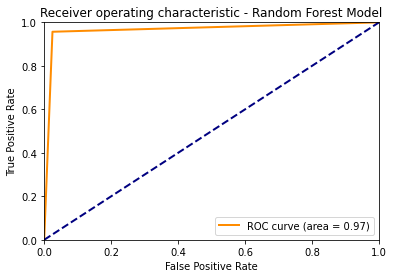

In [20]:
# Plot ROC for Random Forest
fpr, tpr, thresholds = metrics.roc_curve(Y_over, predict_classes(probabilities))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest Model')
plt.legend(loc="lower right")
plt.show()

In [21]:
# Plot confusion matrix
metrics.confusion_matrix(Y_over, predict_classes(probabilities),normalize = "all")

array([[0.48765432, 0.01234568],
       [0.02160494, 0.47839506]])

In [22]:
# Rebuild RFC model
rfc_fit = rfc.fit(X_over, Y_over)

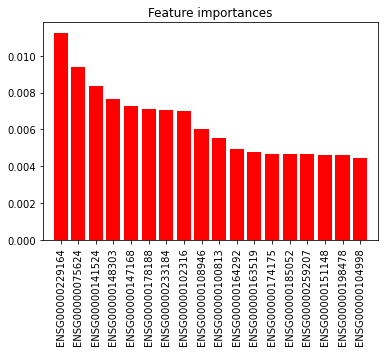

The 18 most important features are: 

Index(['ENSG00000229164', 'ENSG00000075624', 'ENSG00000141524',
       'ENSG00000148303', 'ENSG00000147168', 'ENSG00000178188',
       'ENSG00000233184', 'ENSG00000102316', 'ENSG00000108946',
       'ENSG00000100813', 'ENSG00000164292', 'ENSG00000163519',
       'ENSG00000174175', 'ENSG00000185052', 'ENSG00000259207',
       'ENSG00000151148', 'ENSG00000198478', 'ENSG00000104998'],
      dtype='object')


In [23]:
# Create function to determine the feature importance 
importances = rfc_fit.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(18),importances[indices][:18],color="r", align="center")
plt.xticks(range(18),training_data.T.index[indices][:18],rotation = 90)
plt.xlim([-1, 18])
plt.show()
print('The 18 most important features are: \n')
print(training_data.T.index[indices][:18])

In [24]:
# Determine performance on test set
test_prob = rfc_fit.predict_proba(X_test)

In [25]:
# Metrics for test set
print('Cross validation accuracy:')
print(metrics.accuracy_score(Y_test, predict_classes(test_prob)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Y_test, predict_classes(test_prob)))


Cross validation accuracy:
0.9285714285714286

Cross validation classification report

              precision    recall  f1-score   support

       False       1.00      0.70      0.82        20
        True       0.91      1.00      0.96        64

    accuracy                           0.93        84
   macro avg       0.96      0.85      0.89        84
weighted avg       0.93      0.93      0.92        84



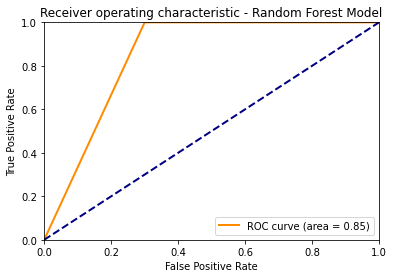

In [26]:
# Plot ROC for Random Forest
fpr, tpr, thresholds = metrics.roc_curve(Y_test, predict_classes(test_prob))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest Model')
plt.legend(loc="lower right")
plt.show()

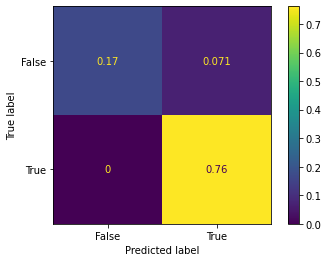

In [27]:
# Plot confusion matrix
metrics.plot_confusion_matrix(rfc_fit,X_test,Y_test,normalize = "all")